In [1]:
import pandas as pd

test_df = pd.read_csv('/kaggle/input/test-dataset123/test.csv')

In [2]:
import pandas as pd

deberta_preds = pd.read_csv('/kaggle/input/second-ai-predictions/predictions_deberta-v3-large.csv')
roberta_preds = pd.read_csv('/kaggle/input/second-ai-predictions/predictions_roberta-base-openai-detector.csv')
xlm_preds = pd.read_csv('/kaggle/input/second-ai-predictions/predictions_xlm-roberta-large-xnli-anli.csv')
xlm_roberta_preds = pd.read_csv('/kaggle/input/second-ai-predictions/predictions_xlm-roberta-large.csv')

In [3]:
data = pd.concat([deberta_preds,roberta_preds,xlm_preds,xlm_roberta_preds],axis=1)

In [4]:
data['label'] = test_df['label']

In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class VotingClassifier:
    def __init__(self, estimators, voting='hard'):
        self.estimators = estimators
        self.voting = voting
        
    def fit(self, X, y):
        for _, estimator in self.estimators:
            estimator.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = pd.DataFrame()
        
        # Get predictions from each classifier
        for name, estimator in self.estimators:
            predictions[name] = estimator.predict(X)
        
        if self.voting == 'hard':
            # Mode of predictions (majority voting)
            final_predictions = predictions.mode(axis=1).iloc[:, 0].values
            return final_predictions
        else:
            raise ValueError("Only 'hard' voting is implemented.")

def evaluate_model(y_true, y_pred):
    """Calculate various metrics for model evaluation"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_macro': f1
    }

def plot_confusion_matrix(y_true, y_pred, labels=None):
    """Plot confusion matrix using seaborn"""
    cm = confusion_matrix(y_true.to_numpy(), y_pred)  # Ensure conversion to array
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels if labels is not None else 'auto',
                yticklabels=labels if labels is not None else 'auto')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Create the individual models
models = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('nb', GaussianNB()),
    ('svc', SVC())  # Removed probability=True since it's unnecessary for hard voting
]

# Create and train the voting classifier
def train_and_evaluate(X, y):
    """Train the voting classifier and evaluate its performance"""
    # Initialize the voting classifier
    voting_clf = VotingClassifier(estimators=models, voting='hard')
    
    # Train the model
    voting_clf.fit(X, y)
    
    # Make predictions
    y_pred = voting_clf.predict(X)
    
    # Evaluate the model
    metrics = evaluate_model(y, y_pred)
    
    # Plot confusion matrix
    plot_confusion_matrix(y, y_pred)
    
    return metrics, voting_clf

# Example usage:
"""
# Assuming your data is already loaded as X and y
metrics, model = train_and_evaluate(X, y)
print("Model Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")
"""


'\n# Assuming your data is already loaded as X and y\nmetrics, model = train_and_evaluate(X, y)\nprint("Model Performance Metrics:")\nfor metric, value in metrics.items():\n    print(f"{metric}: {value:.4f}")\n'

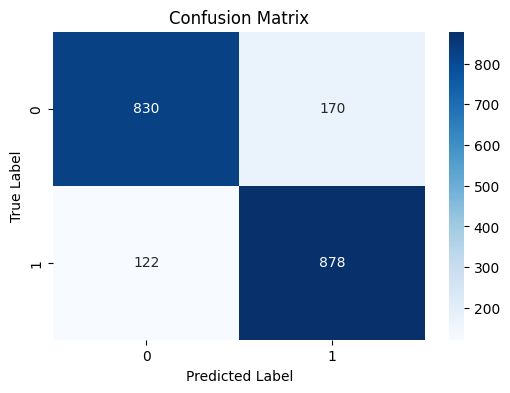

Model Performance Metrics:
accuracy: 0.8540
precision: 0.8548
recall: 0.8540
f1_macro: 0.8539


In [6]:
metrics, model = train_and_evaluate(data.drop('label',axis=1), data.label)
print("Model Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")